In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from scipy.stats import zscore

# set_option to increase max rows displayed to 200, to see entire df in 1 go/
pd.set_option("display.max_rows", 200)

## Read in cost per bus data

In [ ]:
# cleaned FTA Grant Award Press Release Data for buses only
fta = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_bus_cost_clean.csv"
)

In [ ]:
# cleaned TIRCP Project Tracking Data project tracking sheet
tircp = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/tircp_project_bus_only.csv"
)

## Game Plan
- <s>bring in both data sets (FTA Press Release and TIRCP bus data
- <s>FTA data, make sure it only has rows with bus count > 0
- may need to clean up the prop type and bus size type if there are any similar categories (completed at FTA notebook)
- <s>Create shorten data frames for each. include the following columns:
    1. agency name (project_sponsor & grant_recipient)
    2. project title? (project_title)
    3. project award amount (funding and tircp_award_amount($))
    4. bus count (bus_count)
    5. propulsion type (prop_type)
    6. bus size type (bus_size_type)
<br>
<br>
- <s>concat the short dataframes
- <s>start aggregation. sum/count bus count, funding and project #
    * agg by agency name
    * agg by prop type
    * agg by bus size type

- <s>new column for Z-score of `cost_per_bus`
- rerun stats sumamry
- use functions to make charts

In [2]:
# function to display df info
def df_peek(df):
    display(type(df), df.shape, df.dtypes, df.sample(2))

## Read in FTA and TIRCP Data

In [ ]:
# peaking into each dataset
data = [fta, tircp]

for x in data:
    display(x.shape, x.columns, x.head(), x.dtypes)

## Dataset cleaning

### drop some columns

In [ ]:
# examine columns
display(fta.columns, tircp.columns)

In [ ]:
fta = fta.drop(
    columns=[
        "Unnamed: 0",
        "area_served",
        "congressional_districts",
        "fta_region",
        "bus/low-no_program",
    ]
)

In [ ]:
tircp = tircp.drop(
    columns=[
        "Unnamed: 0.2",
        "Unnamed: 0.1",
        "Unnamed: 0",
        "award_year",
        "district",
        "county",
        "total_project_cost",
    ]
)

In [ ]:
display(fta.columns, tircp.columns)

### drop zero bus counts from FTA

In [ ]:
fta = fta[fta["bus_count"] > 0]

In [ ]:
# no more '0' values
fta.bus_count.unique()

## Shorten data frames

FTA & TIRCP columns names respecitvely

    1. agency name (project_sponsor & grant_recipient)
    2. project title? (project_title)
    3. project award amount (funding and tircp_award_amount($))
    4. bus count (bus_count)
    5. propulsion type (prop_type)
    6. bus size type (bus_size_type)

In [ ]:
fta_short = fta[
    [
        "project_sponsor",
        "project_title",
        "funding",
        "bus_count",
        "prop_type",
        "bus_size_type",
    ]
]

In [ ]:
len(fta_short) == len(fta)

In [ ]:
tircp_short = tircp[
    [
        "grant_recipient",
        "project_title",
        "tircp_award_amount_($)",
        "bus_count",
        "prop_type",
        "bus_size_type",
    ]
]

In [ ]:
len(tircp_short) == len(tircp)

## rename columns to match eachother

In [ ]:
# list of new column names. to be applied in same order as short df
new_col = [
    "agency_name",
    "project_title",
    "project_award_amount",
    "bus_count",
    "prop_type",
    "bus_size_type",
]

In [ ]:
fta_short.columns = new_col
tircp_short.columns = new_col

In [ ]:
fta_short.columns == tircp_short.columns

In [ ]:
# add new col to identify source
fta_short["source"] = "fta_press_release"
tircp_short["source"] = "tircp_project_tracking"

In [ ]:
display(fta_short.head(), tircp_short.head())

## Concat both dataframes

In [ ]:
concat = pd.concat([fta_short, tircp_short], axis=0).reset_index()

In [ ]:
display(
    len(fta_short), len(tircp_short), len(fta_short) + len(tircp_short) == len(concat)
)

In [ ]:
concat.sample(3)

In [ ]:
concat = concat.drop("index", axis=1)

In [ ]:
# concat looks good
list(concat.prop_type.sort_values().unique())

## Export concat data

In [ ]:
concat.to_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv"
)

### Read in concat data (TIRCP and FTA data)

In [3]:
all_bus = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv"
)

## create cost_per_bus_column
on all_bus df

In [4]:
all_bus["cost_per_bus"] = (
    all_bus["project_award_amount"] / all_bus["bus_count"]
).astype("int64")

In [5]:
df_peek(all_bus)

pandas.core.frame.DataFrame

(133, 9)

Unnamed: 0                int64
agency_name              object
project_title            object
project_award_amount      int64
bus_count               float64
prop_type                object
bus_size_type            object
source                   object
cost_per_bus              int64
dtype: object

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus
96,96,Antelope Valley Transit Authority (AVTA),Regional Transit Interconnectivity & Environme...,24403000,29.0,electric (not specified),conventional (40-ft like),tircp_project_tracking,841482
119,119,Contra Costa Transportation Authority (CCTA),I-680 Express Bus Program,14460000,6.0,zero-emission bus (not specified),not specified,tircp_project_tracking,2410000


## Aggregate
To get total funding and bus count
- per agency
- per propulsion type
- per bus size type

In [6]:
## function to agg by X col by project title, award and bus count

def bus_aggregate(column):
    df_agg = (
        all_bus.groupby(column)
        .agg(
            total_project_count=("project_title", "count"),
            total_funds=("project_award_amount", "sum"),
            total_bus_count=("bus_count", "sum"),
        )
        .reset_index()
    )
    return df_agg

In [7]:
agency_agg = bus_aggregate("agency_name")
prop_agg = bus_aggregate("prop_type")
size_agg = bus_aggregate("bus_size_type")

In [11]:
# list and loop to look at all agg dfs at the same time
agg_list =[agency_agg,
          prop_agg,
          size_agg]

for x in agg_list:
    display(df_peek(x))

pandas.core.frame.DataFrame

(127, 4)

agency_name             object
total_project_count      int64
total_funds              int64
total_bus_count        float64
dtype: object

,agency_name,total_project_count,total_funds,total_bus_count
107,Texas Department of Transportation on behalf o...,1,7443765,56.0
9,Champaign-Urbana Mass Transit District,1,6635394,10.0


None

pandas.core.frame.DataFrame

(11, 4)

prop_type               object
total_project_count      int64
total_funds              int64
total_bus_count        float64
dtype: object

,prop_type,total_project_count,total_funds,total_bus_count
1,CNG,15,234921904,330.0
3,electric (not specified),20,337174822,206.0


None

pandas.core.frame.DataFrame

(4, 4)

bus_size_type           object
total_project_count      int64
total_funds              int64
total_bus_count        float64
dtype: object

,bus_size_type,total_project_count,total_funds,total_bus_count
1,cutaway,4,32861322,183.0
2,not specified,122,1944679469,2418.0


None

## Z-score for cost_per_bus 

In [12]:
# add new column for z-score
all_bus["zscore_cost_per_bus"] = zscore(all_bus["cost_per_bus"])

In [13]:
df_peek(all_bus)

pandas.core.frame.DataFrame

(133, 10)

Unnamed: 0                int64
agency_name              object
project_title            object
project_award_amount      int64
bus_count               float64
prop_type                object
bus_size_type            object
source                   object
cost_per_bus              int64
zscore_cost_per_bus     float64
dtype: object

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus,zscore_cost_per_bus
33,33,Illinois Department of Transportation on behal...,Illinois Department of Transportation Statewid...,12299377,50.0,BEB,not specified,fta_press_release,245987,-0.701328
89,89,The Colorado Department of Transportation (CDO...,Mountain Express Low-E Fleet Replacement and E...,753118,3.0,low emission (propane),not specified,fta_press_release,251039,-0.696832


In [14]:
# remove outliers
# filter df for zscores between -3 and 3
zscore_bus = all_bus[
    (all_bus["zscore_cost_per_bus"] >= -3) & (all_bus["zscore_cost_per_bus"] <= 3)
]

In [20]:
# check work

# 2 rows were dropped
# max and min are withing -3 to 3
display(len(zscore_bus),
        zscore_bus.zscore_cost_per_bus.max(),
        zscore_bus.zscore_cost_per_bus.min())

131

2.3732393072982587

-0.8879722054734137

## Stats Analysis

In [56]:
cpb_mean = filtered.cost_per_bus.mean()
cpb_std = filtered.cost_per_bus.std()

In [57]:
cpb_mean, cpb_std

(932164.8702290077, 735398.2780645975)

## Summary

In [ ]:
all_bus.columns

In [66]:
# Variables
total_unique_projects = len(all_bus)
total_bus_count = sum(all_bus.bus_count)
total_funding = sum(all_bus.project_award_amount)
min_bus_cost = all_bus.cost_per_bus.min()
max_bus_cost = all_bus.cost_per_bus.max()
max_bus_count = all_bus.bus_count.max()

cpb_mean = filtered.cost_per_bus.mean()
cpb_std = filtered.cost_per_bus.std()

agency_with_most_bus = all_bus.loc[all_bus["bus_count"].idxmax(), "agency_name"]
# how many buses do they have? already answered
agency_with_highest_funds = all_bus.loc[
    all_bus["project_award_amount"].idxmax(), "agency_name"
]
# what is the highest amount? already answered
agency_max_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmax(), "agency_name"]
agency_min_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmin(), "agency_name"]

In [67]:
summary = f"""
As of today, data was scraped from mutltiple sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federaly funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    
Data from DGS usage reports, Georgia and Washington contracts to be analyzed next.

Note, some projects included additional compoments besides bus purchases (chargers, transit facilities, parts, training) which may cause project costs to increase dramaticly, whereas other projects specified only bus purcahses, and some did not include and bus purchases at all.

Datasets was filtered to only include data that specificed the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per_bus' metric was calculated by dividing the total funding the agency received by the total number of buses they specify.

In total:
    - {total_unique_projects} projects with bus purchases were analyzed.
    - ${total_funding:,.2f} was awarded to agencies for projects including bus purchases.
    - {total_bus_count} total buses are to be purchased.
    - The highest cost per bus for an agency was ${max_bus_cost:,.2f}, belonging too {agency_max_cpb} 
    - The lowest cost per bus for an agency was ${min_bus_cost:,.2f}, belonging too {agency_min_cpb}
    

The agency with the most buses specified was {agency_with_most_bus} with {max_bus_count} buses.

After removing outliers, the following was discovered:
    - the mean cost per bus is ${mean:,.2f}.
    - the standard deviation is ${std_dev:,.2f}. 

Below are charts that summarize the data.
"""

In [68]:
print(summary)


As of today, data was scraped from mutltiple sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federaly funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    
Data from DGS usage reports, Georgia and Washington contracts to be analyzed next.

Note, some projects included additional compoments besides bus purchases (chargers, transit facilities, parts, training) which may cause project costs to increase dramaticly, whereas other projects specified only bus purcahses, and some did not include and bus purchases at all.

Datasets was filtered to only include data that specificed the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per_bus' metric was calculated by dividing the total funding the agency received by the total number of buses they specify.

In total:
    - 133 projects with bus purchases were analyzed.
    - $2,065,774,791.00 was awarded to agencies for projects including bus purc

In [43]:
# chart function
def make_chart(y_col, title, x_col='agency_name'):
    zscore_bus.sort_values(by=y_col, ascending=False).head(10).plot(
        x=x_col, y=y_col, kind="bar", color="skyblue"
    )
    plt.title(title)
    plt.xlabel("Transit Agnecies")
    plt.ylabel(y_col)
    plt.show()

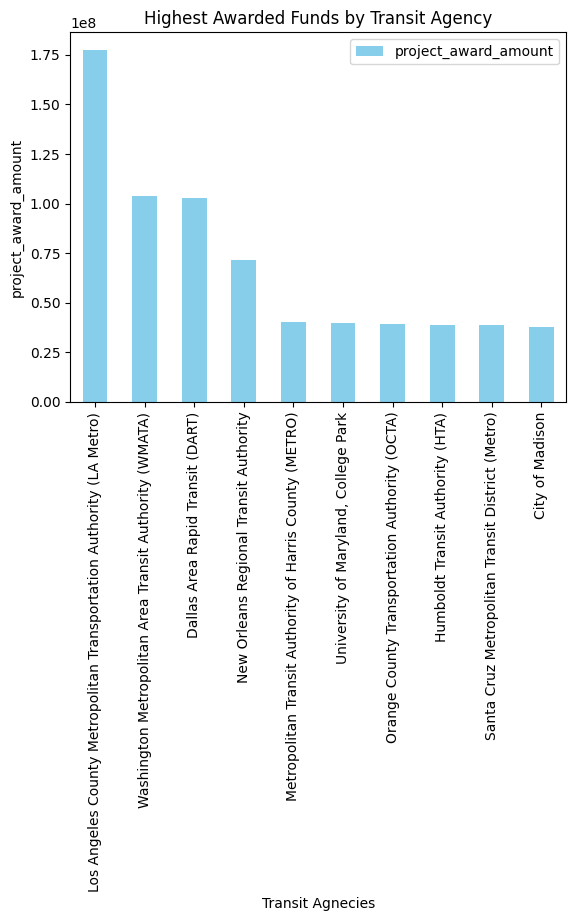

In [44]:
# Higest awarded funds by agency
make_chart('project_award_amount','Highest Awarded Funds by Transit Agency')

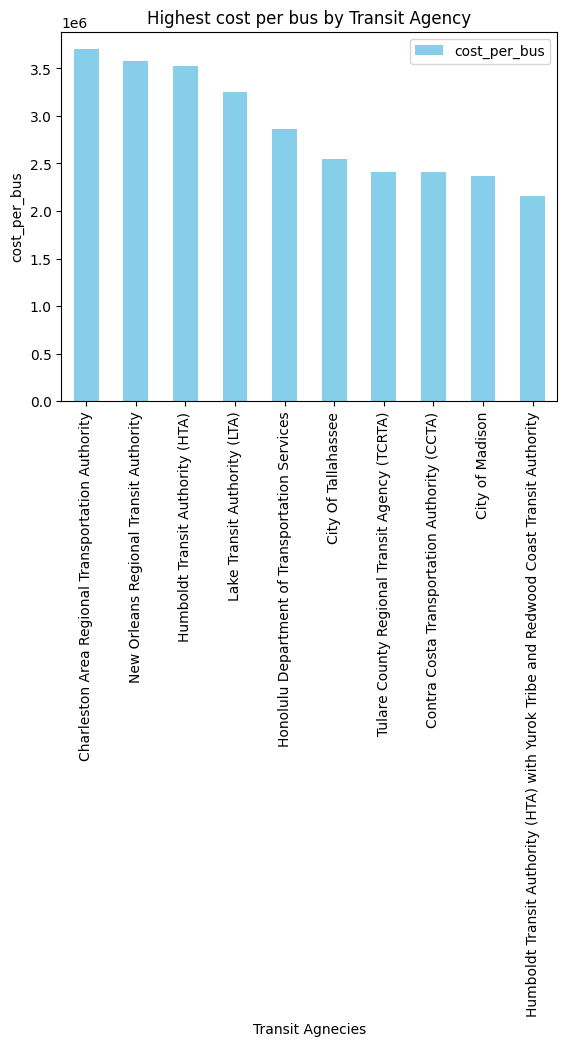

In [45]:
# highest cost per bus by agency
make_chart('cost_per_bus','Highest cost per bus by Transit Agency')

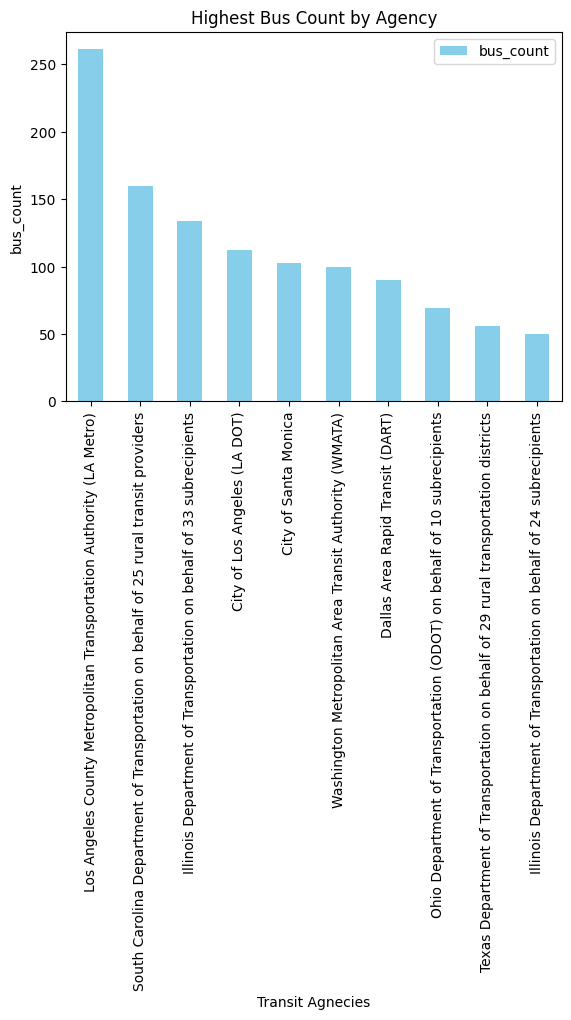

In [46]:
# Highest bus count
make_chart('bus_count', 'Highest Bus Count by Agency')

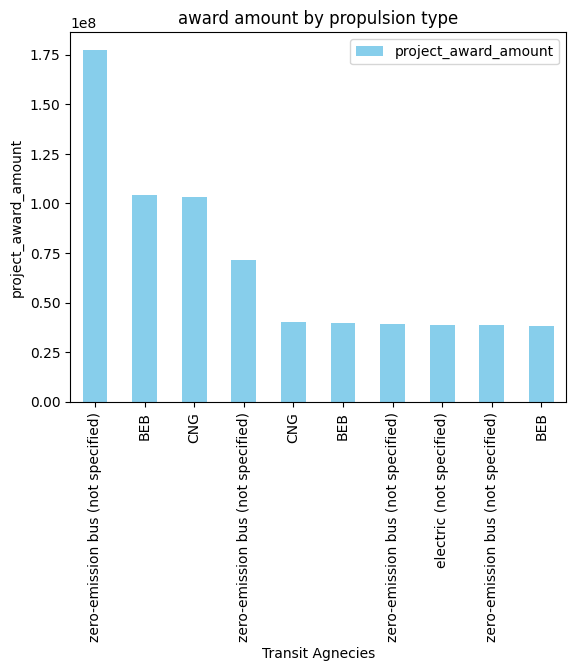

In [47]:
# COST PER BUS BY PROP TYPE
make_chart('project_award_amount','award amount by propulsion type', x_col='prop_type')

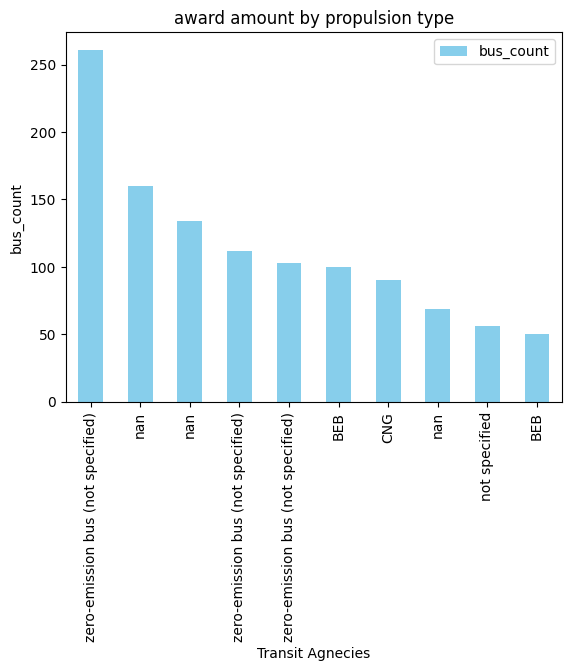

In [48]:
# COST PER BUS BY PROP TYPE
make_chart('bus_count','bus count by propulsion type', x_col='prop_type')

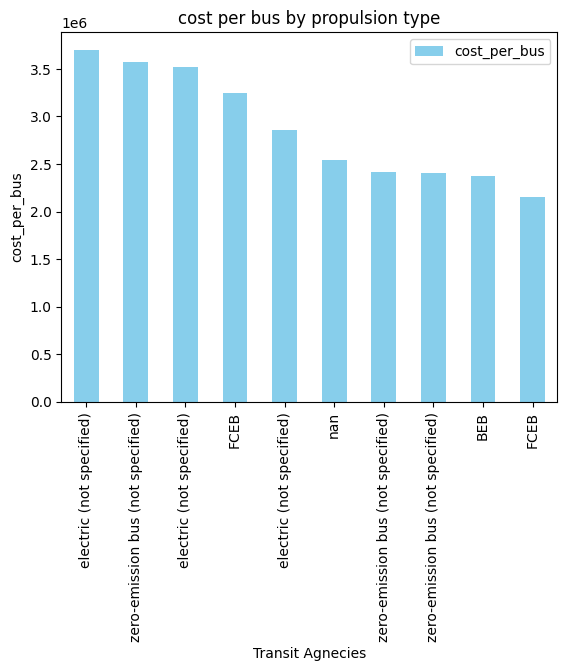

In [49]:
# COST PER BUS BY PROP TYPE
make_chart('cost_per_bus','cost per bus by propulsion type', x_col='prop_type')

In [ ]:
# bar chart of highest bus count
concat.sort_values(by="bus_count", ascending=False).head(10).plot(
    x="project_sponsor", y="bus_count", kind="bar", color="skyblue"
)
plt.title("Top 10 Agencies with most bus count")
plt.xlabel("Transit Agnecies")
plt.ylabel("# of buses")
plt.show()

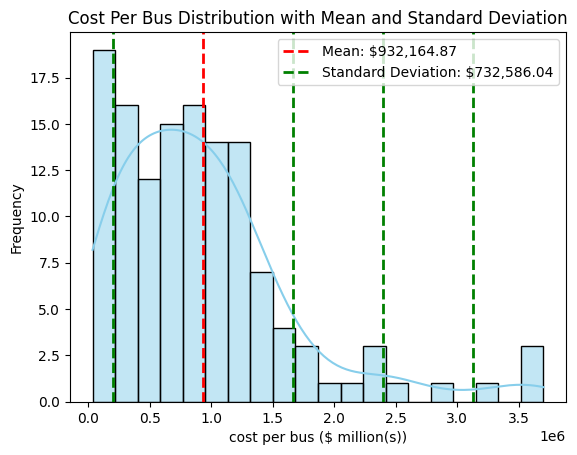

In [80]:
# distribution curve of cost per bus. no outliers
sns.histplot(filtered["cost_per_bus"], kde=True, color="skyblue", bins=20)
plt.axvline(
    mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
)
plt.axvline(
    mean + std_dev,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Standard Deviation: ${std_dev:,.2f}",
)
plt.axvline(mean - std_dev, color="green", linestyle="dashed", linewidth=2)
plt.axvline(mean + std_dev * 2, color="green", linestyle="dashed", linewidth=2)
plt.axvline(mean + std_dev * 3, color="green", linestyle="dashed", linewidth=2)

plt.title("Cost Per Bus Distribution with Mean and Standard Deviation")
plt.xlabel("cost per bus ($ million(s))")
plt.ylabel("Frequency")
plt.legend()
plt.show()

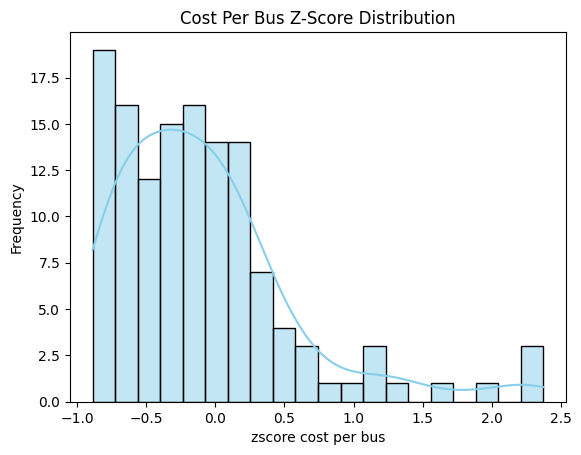

In [81]:
# distribution curve of zscore
sns.histplot(filtered["zscore_cost_per_bus"], kde=True, color="skyblue", bins=20)
# plt.axvline(mean2, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean2:.2f}')
# plt.axvline(mean2 + std_dev2, color='green', linestyle='dashed', linewidth=2, label=f'Standard Deviation: {std_dev2:,.2f}')
# plt.axvline(mean2 - std_dev2, color='green', linestyle='dashed', linewidth=2)
# plt.axvline(mean2 + (std_dev2*2), color='green', linestyle='dashed', linewidth=2)
# plt.axvline(mean2 + (std_dev2*3), color='green', linestyle='dashed', linewidth=2)
# plt.axvline(mean2 - (std_dev2*2), color='green', linestyle='dashed', linewidth=2)
# plt.axvline(mean2 - (std_dev2*3), color='green', linestyle='dashed', linewidth=2)

plt.title("Cost Per Bus Z-Score Distribution")
plt.xlabel("zscore cost per bus")
plt.ylabel("Frequency")
plt.show()